In [2]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from enum import Enum
import collections
from pylab import meshgrid
import pyfftw


%matplotlib inline

class FIELD(Enum):
        ELECTRIC = [1,['0_0', '0_1', '0_2']]
        CURRENT = [1,['1_0', '1_1', '1_2']]
        VELOCION = [1,['2_0', '2_1', '2_2']]
        DENSELEC = [1,['3_0']]
        PRESSURE = [1,['4_0', '4_1', '4_2','4_3', '4_4', '4_5']]
        DENSITY = [1,['5_0']]
        VELOCITY = [1,['5_1', '5_2', '5_3']]
        DENSITY1 = [1,['6_0']]
        VELOCITY1 = [1,['6_1', '6_2', '6_3']]
        MAGNETIC = [1,['7_0', '7_1', '7_2']]
    

                    
def loadData(filePath):           
        f = h5py.File(filePath)
        allData = collections.defaultdict(lambda: np.ndarray(0))
        for fld in FIELD:
                VAR0_name = 'vars/'+fld.value[1][0]
                SHAPE = f[VAR0_name].shape            
                Lx=SHAPE[0]
                Ly=SHAPE[1]
                Lz=SHAPE[2]
                data = np.zeros([Lx, Ly, Lz,  6])
                idx = 0
                for field in fld.value[1]:
                    VAR_name = 'vars/'+field
                    data[...,idx] = f[VAR_name][...]
                    idx += 1
                    allData[fld] = data                   
        f.close()
        return allData
        
        
def loadVar(filePath, fld):           
        f = h5py.File(filePath)
        allData = collections.defaultdict(lambda: np.ndarray(0))
        VAR0_name = 'vars/'+fld.value[1][0]
        SHAPE = f[VAR0_name].shape    
        Lx=SHAPE[0]
        Ly=SHAPE[1]
        Lz=SHAPE[2]
        data = np.zeros([Lx, Ly, Lz, len(fld.value[1])])
        idx = 0
        for field in fld.value[1]:
            VAR_name = 'vars/'+field
            data[...,idx] = f[VAR_name]
            idx += 1
            
        f.close()
        return data
    
    
class FTR(Enum):
        __order__ = 'B_0 B_1 A_Z'
        B_0 = ['bxo', 'byo']
        B_1 = ['bx1', 'by1']
        A_Z = ['azo', 'az1']
        
def fourierFlux(bfield, domsize, zslice=0) :
            dim = [bfield.shape[0], bfield.shape[1]]
            d = dict()
            for f in FTR:
                d[f.value[0]] = pyfftw.empty_aligned(dim, dtype = 'complex128')
                d[f.value[1]] = pyfftw.empty_aligned(dim, dtype = 'complex128')
            
            for axis in range(2):
                fftXY = pyfftw.FFTW(d[FTR.B_0.value[axis]], d[FTR.B_1.value[axis]], axes=(0, 1), 
                                  direction='FFTW_FORWARD', flags=('FFTW_MEASURE', ))                
                d[FTR.B_0.value[axis]].real[...] = bfield[...,zslice, axis]
                d[FTR.B_0.value[axis]].imag = np.zeros(dim, dtype = float)
                fftXY.update_arrays(d[FTR.B_0.value[axis]], d[FTR.B_1.value[axis]])
                pyfftw.FFTW.execute(fftXY)
            
            wy, wx = meshgrid(np.fft.fftfreq(dim[1], 1.0/dim[1])/domsize[1], 
                              np.fft.fftfreq(dim[0], 1.0/dim[0])/domsize[0])
            k2 = np.square(2*np.pi*wx)+np.square(2*np.pi*wy)
            k2[0][0] = 1.0
            
            fftBack = pyfftw.FFTW(d[FTR.A_Z.value[0]], d[FTR.A_Z.value[1]], axes=(0, 1), 
                                  direction='FFTW_BACKWARD', flags=('FFTW_MEASURE',))            
            d[FTR.A_Z.value[1]] = np.divide(1j*(wx*d[FTR.B_1.value[1]]-wy*d[FTR.B_1.value[0]]), k2)
            d[FTR.A_Z.value[1]][0][0] = 0.0
            fftBack.update_arrays(d[FTR.A_Z.value[1]], d[FTR.A_Z.value[0]])
            pyfftw.FFTW.execute(fftBack)
            return d[FTR.A_Z.value[0]].real

/Applications/anaconda/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.0993358596796523 -1.555908466358182


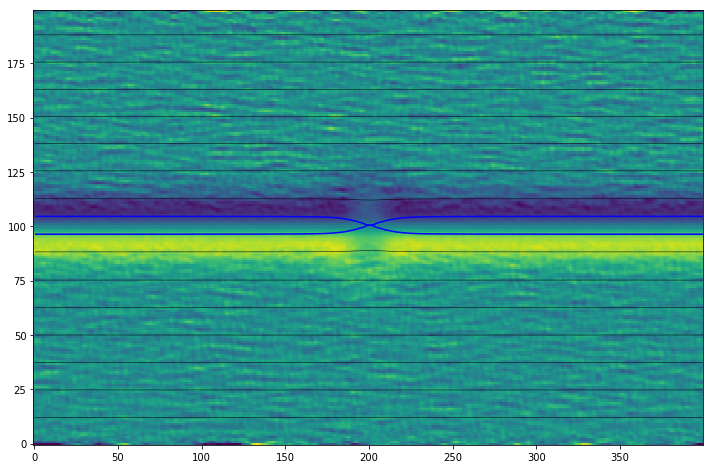

In [16]:
filePath = '../harris_out/'
fileName = 'harris_1.h5'

data2Plt = loadVar(filePath+fileName, FIELD.ELECTRIC)[...,0,1]
print data2Plt.max(), data2Plt.min()

fig, ax = plt.subplots(1,1, figsize = [12, 8], dpi = 100) 

vmax = 1.1
ax.imshow( np.transpose(data2Plt),aspect='auto', origin = 'lower', interpolation="nearest", 
               vmin = -vmax, vmax = vmax)

flux = fourierFlux( loadVar(filePath+fileName, FIELD.MAGNETIC), [1,1], 0) 

ax.contour(np.transpose(flux), flines = None,colors = ('k',),origin = 'lower',
                                  linestyles = 'solid',linewidths = 0.5)

flux0 = flux[200,100]
ax.contour(np.transpose(flux - flux0), levels = [0.0], colors = ('b',),origin = 'lower',
                                  linestyles = 'solid',linewidths = 1.5)
